In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-data/Crop data/Corn_(maize)___Northern_Leaf_Blight/efb9c96a-22d4-4217-bf2b-7c0f5d97d277___RS_NLB 4057 copy 2.jpg
/kaggle/input/crop-data/Crop data/Corn_(maize)___Northern_Leaf_Blight/cbd7b12a-7a46-4493-bba9-4712c54a3657___RS_NLB 3700.JPG
/kaggle/input/crop-data/Crop data/Corn_(maize)___Northern_Leaf_Blight/0d0f6d14-be5c-4cb8-adb4-2cfd4d5f8540___RS_NLB 3642.JPG
/kaggle/input/crop-data/Crop data/Corn_(maize)___Northern_Leaf_Blight/e4a1bfbf-22a0-4455-98e2-a1bd0a243a94___RS_NLB 3975_180deg.JPG
/kaggle/input/crop-data/Crop data/Corn_(maize)___Northern_Leaf_Blight/811ac5c3-9079-43aa-ba29-8b1bc35dd156___RS_NLB 4069_flipTB.JPG
/kaggle/input/crop-data/Crop data/Corn_(maize)___Northern_Leaf_Blight/060f9d88-a58d-43d9-9c97-90acc56627ff___RS_NLB 4227_flipTB.JPG
/kaggle/input/crop-data/Crop data/Corn_(maize)___Northern_Leaf_Blight/cd8e6562-3a13-4c9c-9fdb-55df3e8f578a___RS_NLB 3854_flipTB.JPG
/kaggle/input/crop-data/Crop data/Corn_(maize)___Northern_Leaf_Blight/d317e749-6b6b-44b2-9

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers


import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [3]:
#Generating data paths with labels
def define_paths(data_dir):
    image_paths = []
    labels = []
    
    # for each subfolder (class) in the data_dir
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        
        # Only proceed if it’s actually a directory
        if os.path.isdir(class_path):
            # now list all files in that class folder
            for filename in os.listdir(class_path):
                file_path = os.path.join(class_path, filename)
                # check if it's a file (and presumably an image)
                if os.path.isfile(file_path):
                    image_paths.append(file_path)
                    labels.append(class_name)

    return image_paths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Splitting dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [4]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''



    img_size = (224, 224)
    channels = 3 # either RGB or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)


    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)


    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [5]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    # calculate number of displayed samples
    length = len(labels)
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()


In [6]:
def split_data(data_dir):
    """
    This function extracts only the required four classes, renames them, and splits the dataset into train, validation, and test sets.
    """
    # Mapping of original class names to new names
    class_mapping = {
        "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot": "Gray_leaf_spot",
        "Corn_(maize)___Common_rust_": "Common rust",
        "Corn_(maize)___Northern_Leaf_Blight": "Northern leaf blight",
        "Corn_(maize)___healthy": "healthy"
    }

    image_paths = []
    labels = []

    # Scan directory and collect file paths + labels
    for original_name, new_name in class_mapping.items():
        class_path = os.path.join(data_dir, original_name)

        if os.path.exists(class_path):  # Ensure the folder exists
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                image_paths.append(img_path)
                labels.append(new_name)  # Apply renamed class label

    # Create DataFrame
    df = pd.DataFrame({'filepaths': image_paths, 'labels': labels})

    # Debugging: Check if the DataFrame is correctly created
    print("DataFrame Preview:\n", df.head())  # ✅ Debugging Step
    print("Columns:", df.columns.tolist())  # ✅ Debugging Step
    print("Unique Labels:", df['labels'].unique())  # ✅ Ensure labels are renamed correctly

    # Shuffle the data
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split into train (70%), validation (15%), and test (15%)
    train_df = df.sample(frac=0.7, random_state=42)
    remaining_df = df.drop(train_df.index)

    valid_df = remaining_df.sample(frac=0.5, random_state=42)  # 15%
    test_df = remaining_df.drop(valid_df.index)  # 15%

    return train_df, valid_df, test_df

In [7]:
# ✅ Call the function
data_dir = '/kaggle/input/crop-data/Crop data'
train_df, valid_df, test_df = split_data(data_dir)

# Generators
batch_size = 32
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

DataFrame Preview:
                                            filepaths          labels
0  /kaggle/input/crop-data/Crop data/Corn_(maize)...  Gray_leaf_spot
1  /kaggle/input/crop-data/Crop data/Corn_(maize)...  Gray_leaf_spot
2  /kaggle/input/crop-data/Crop data/Corn_(maize)...  Gray_leaf_spot
3  /kaggle/input/crop-data/Crop data/Corn_(maize)...  Gray_leaf_spot
4  /kaggle/input/crop-data/Crop data/Corn_(maize)...  Gray_leaf_spot
Columns: ['filepaths', 'labels']
Unique Labels: ['Gray_leaf_spot' 'Common rust' 'Northern leaf blight' 'healthy']
Found 5120 validated image filenames belonging to 4 classes.
Found 1098 validated image filenames belonging to 4 classes.
Found 1097 validated image filenames belonging to 4 classes.


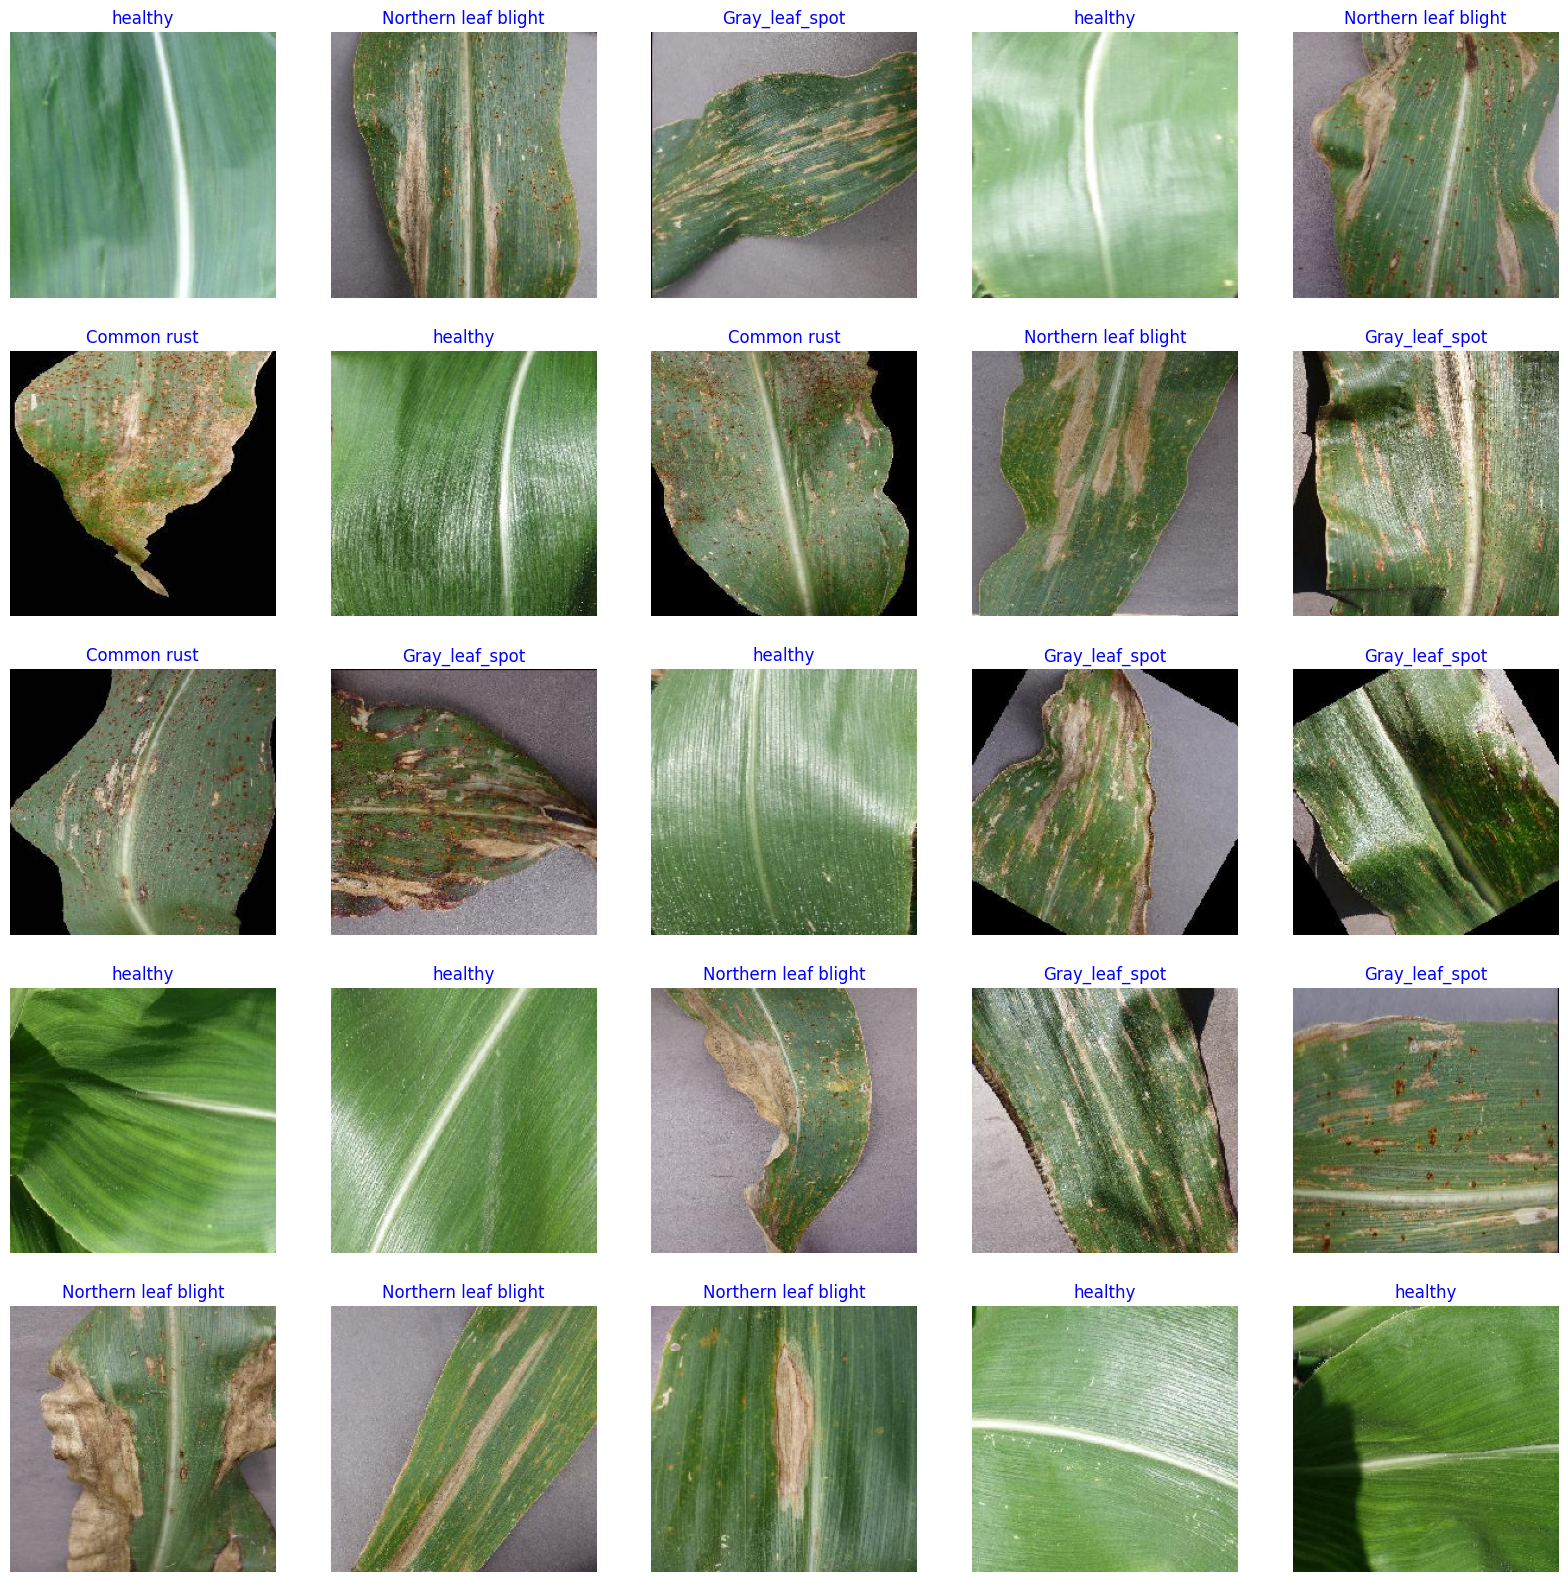

In [8]:
show_images(train_gen)

In [9]:
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
base_model = NASNetMobile(weights='imagenet', include_top=False,pooling='max')
#base_model.trainable = False
x = base_model.output
x= Dense(256, activation='relu')(x)
x=Dropout(0.3)(x)
x= Dense(128, activation='relu')(x)
x=Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

model =Model(inputs=base_model.input, outputs=predictions)


optimizer = Adamax(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()



19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 111, 111, 32)   │            128 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 111, 111, 11)   │            352 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 111, 111, 11)   │             44 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 111, 111, 11)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 111, 111, 32)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 115, 115, 11)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 117, 117, 32)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │            396 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 56, 56, 11)     │          1,920 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 56, 56, 11)     │             44 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 56, 56, 11)     │              0 │ separable_conv_1_bn_r… │
├──────────────────────

 Total params: 4,573,720 (17.45 MB)

 Trainable params: 4,536,982 (17.31 MB)

 Non-trainable params: 36,738 (143.51 KB)

In [10]:
history = model.fit(train_gen, epochs=50, validation_data=valid_gen)

Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 229s 369ms/step - accuracy: 0.5175 - loss: 1.7709 - val_accuracy: 0.2523 - val_loss: 2.0885
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 228ms/step - accuracy: 0.8612 - loss: 0.3701 - val_accuracy: 0.3971 - val_loss: 1.3551
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.9110 - loss: 0.2360 - val_accuracy: 0.5510 - val_loss: 1.1084
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.9440 - loss: 0.1599 - val_accuracy: 0.6776 - val_loss: 0.8221
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.9483 - loss: 0.1350 - val_accuracy: 0.7596 - val_loss: 0.6152
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 227ms/step - accuracy: 0.9702 - loss: 0.0884 - val_accuracy: 0.8078 - val_loss: 0.5024
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 228ms/step - accuracy: 0.9679 - loss: 0.0866 - val_accuracy: 0.8251 - val_loss: 0.4266
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 37s 229ms/step - accuracy: 0.9746 - loss: 

In [11]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(test_gen)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1097/1097 ━━━━━━━━━━━━━━━━━━━━ 29s 19ms/step - accuracy: 0.9932 - loss: 0.0357
Test Loss: 0.04285867139697075
Test Accuracy: 0.9917957782745361


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

In [13]:
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

# True labels from the test generator
true_classes = test_gen.classes


class_names = list(test_gen.class_indices.keys())

# Generating the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)

print(report)

1097/1097 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step
                      precision    recall  f1-score   support

         Common rust       1.00      1.00      1.00       300
      Gray_leaf_spot       0.99      0.97      0.98       217
Northern leaf blight       0.98      0.99      0.99       301
             healthy       1.00      1.00      1.00       279

            accuracy                           0.99      1097
           macro avg       0.99      0.99      0.99      1097
        weighted avg       0.99      0.99      0.99      1097



1097/1097 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step


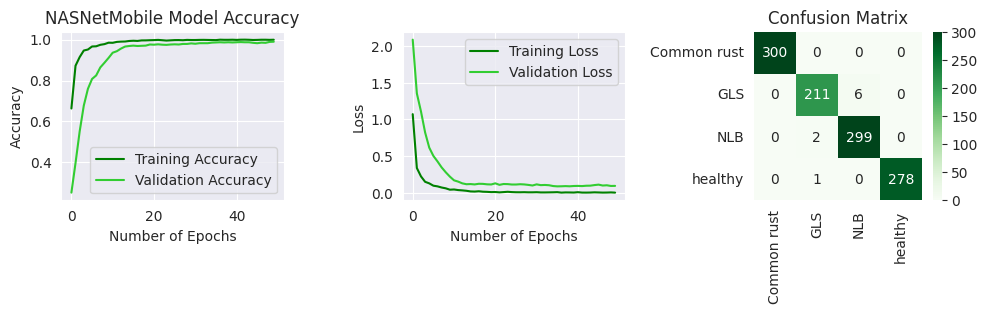

In [14]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure for the subplots
plt.figure(figsize=(10, 3))

# Plot training and validation accuracy
plt.subplot(1, 3, 1)
plt.plot(train_accuracy, label='Training Accuracy', color='green')
plt.plot(val_accuracy, label='Validation Accuracy', color='limegreen')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('NASNetMobile Model Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 3, 2)
plt.plot(train_loss, label='Training Loss', color='green')
plt.plot(val_loss, label='Validation Loss', color='limegreen')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
# plt.title('NASNetMobile Model Loss')
plt.legend()

# Get predictions for the test data
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels for the test data
true_classes = test_gen.classes

# Update class labels
class_labels = list(test_gen.class_indices.keys())
class_labels[class_labels.index('Northern leaf blight')] = 'NLB'
class_labels[class_labels.index('Gray_leaf_spot')] = 'GLS'

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, y_pred_classes)

# Plot confusion matrix
plt.subplot(1, 3, 3)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', square=True,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()